<a href="https://colab.research.google.com/github/sushirito/Hg2/blob/main/Copy_of_1D_Diffusion_Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
!pip install pyDOE
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pyDOE import lhs
from scipy.integrate import odeint
import time
import scipy.special as sp

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
print(torch.__version__)
torch.manual_seed(31)
np.random.seed(31)

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=ab5747c26467cfebfe409ef3c9bf4a2250ceab96a44d5a2df8e8a76d9632b2aa
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE
cuda
2.5.1+cu124


#Utils and MLP Class

In [6]:
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

def nptoTensor(data):
    return torch.from_numpy(data).to(device).float()

class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        for i in range(len(layers)-2):
            z = self.linears[i](x)
            x = self.activation(z)
        x = self.linears[-1](x)
        return x

    def loss_bc_dirichlet(self, x, y):
        loss_d = self.loss_function(self.forward(x), y)
        return loss_d

    def loss_bc_neumann(self, x_neumann):
        x_neumann.requires_grad = True
        p = self.forward(x_neumann)
        p_grad = gradients(p, x_neumann)[0]
        p_x = p_grad[:, 0:1]
        loss_n = self.loss_function(p_x, torch.zeros_like(p_x))
        return loss_n

    def loss_internal(self, x_train):
        x_train.requires_grad = True
        p = self.forward(x_train)
        p_grad = gradients(p, x_train)[0]
        c_x = p_grad[:, 0:1]
        c_t = p_grad[:, 1:2]
        c_xx = gradients(c_x, x_train)[0][:, 0:1]
        pde = c_t - D * c_xx
        loss_pde = pde.pow(2).mean()
        return loss_pde

    def loss(self, x_dirichlet, y_dirichlet, x_neumann, x_to_train_f):
        loss_D = self.loss_bc_dirichlet(x_dirichlet, y_dirichlet)
        loss_N = self.loss_bc_neumann(x_neumann)
        loss_F = self.loss_internal(x_to_train_f)
        total_loss = loss_D + loss_N + loss_F
        return total_loss, loss_D, loss_N, loss_F

def trainingdata(Nx, Nt, Nf, Nu_D, Nu_N):
    x = np.linspace(0, 1, Nx)
    t = np.linspace(0, 1, Nt)
    init_cond = np.hstack((x[:, None], np.zeros((Nx, 1))))
    c_init = np.zeros((Nx, 1))
    left_bc = np.hstack((np.zeros((Nt, 1)), t[:, None]))
    c_left = c0 * np.ones((Nt, 1))
    bc_dirichlet = np.vstack((init_cond, left_bc))
    bc_c_dirichlet = np.vstack((c_init, c_left))
    idxD = np.random.choice(bc_dirichlet.shape[0], Nu_D)
    x_dirichlet = bc_dirichlet[idxD, :]
    y_dirichlet = bc_c_dirichlet[idxD, :]
    neumann_bc = np.hstack((np.ones((Nt, 1)), t[:, None]))
    idxN = np.random.choice(neumann_bc.shape[0], Nu_N)
    x_neumann = neumann_bc[idxN, :]
    f_train = lhs(2, Nf)
    return x_dirichlet, y_dirichlet, x_neumann, f_train

c0 = 1.0


#Data Prep and PINN Training

Epoch: 100, MSE: 0.007111
Epoch: 200, MSE: 0.007111
Epoch: 300, MSE: 0.007111
Epoch: 400, MSE: 0.007111
Epoch: 500, MSE: 0.007111
Epoch: 600, MSE: 0.007111
Epoch: 700, MSE: 0.007111
Epoch: 800, MSE: 0.007111
Epoch: 900, MSE: 0.007111
Epoch: 1000, MSE: 0.007111
Total training time in minutes: 0.28437819878260295


<ipython-input-7-d6572fac6b7c>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp.load_state_dict(torch.load(path))
<ipython-input-7-d6572fac6b7c>:41: FutureWarning: You 

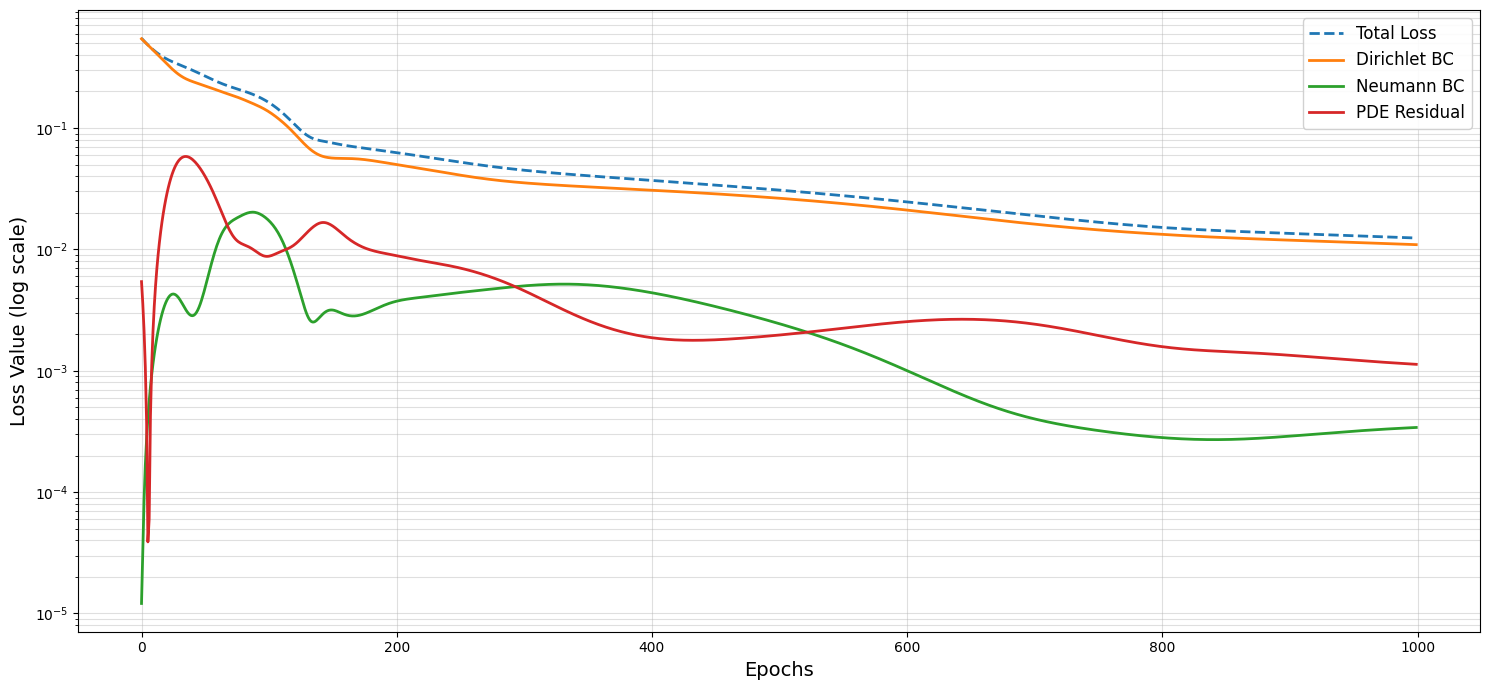

In [7]:
Nu_D = 300
Nu_N = 300
N_x = 100
N_t = 100
N_f = 10000

x_dirichlet_np, y_dirichlet_np, x_neumann_np, f_train_np = trainingdata(N_x, N_t, N_f, Nu_D, Nu_N)
x_dirichlet = nptoTensor(x_dirichlet_np)
y_dirichlet = nptoTensor(y_dirichlet_np)
x_neumann = nptoTensor(x_neumann_np)
f_train = nptoTensor(f_train_np)

D = 0.1
layers = np.array([2, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 1])
mlp = MLP(layers).to(device)
step_size = 20000
gamma = 0.5
A_hist = []
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001)
max_iter = 1000

tic = time.time()
for i in range(max_iter):
    total_loss, loss_D, loss_N, loss_F = mlp.loss(x_dirichlet, y_dirichlet, x_neumann, f_train)
    A_hist.append([i, total_loss.item(), loss_D.item(), loss_N.item(), loss_F.item()])
    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i+1) % 100 == 0:
         print("Epoch: {}, MSE: {:.6f}".format((i+1), loss.item()))
toc = time.time()
print(f'Total training time in minutes: {(toc-tic)/60}')

path = '1D-SoluteDiffusion_PDE_trained.pth'
torch.save(mlp.state_dict(), path)
path = '/content/1D-SoluteDiffusion_PDE_trained.pth'
mlp.load_state_dict(torch.load(path))
mlp.eval()

model = MLP(layers)
state_dict = torch.load('/content/1D-SoluteDiffusion_PDE_trained.pth')
model.load_state_dict(state_dict)
model.eval()
example = torch.rand(1, 2)
traced_script_module = torch.jit.trace(model, example)
torch.jit.save(traced_script_module, "SoluteDiffusion_PDE.pt")
loaded = torch.jit.load("SoluteDiffusion_PDE.pt")

A_hist = np.array(A_hist)
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)

components = [
    ('Total Loss', 1, '--'),
    ('Dirichlet BC', 2, '-'),
    ('Neumann BC', 3, '-'),
    ('PDE Residual', 4, '-')
]

for label, idx, style in components:
    ax.plot(A_hist[:, 0], A_hist[:, idx], linewidth=2,
            linestyle=style, label=label)

ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss Value (log scale)', fontsize=14)
ax.legend(fontsize=12, framealpha=0.9)
ax.grid(True, which='both', alpha=0.4)
ax.semilogy()
plt.tight_layout()
plt.savefig('loss_components.png', dpi=300, bbox_inches='tight')

#FDM Simulation


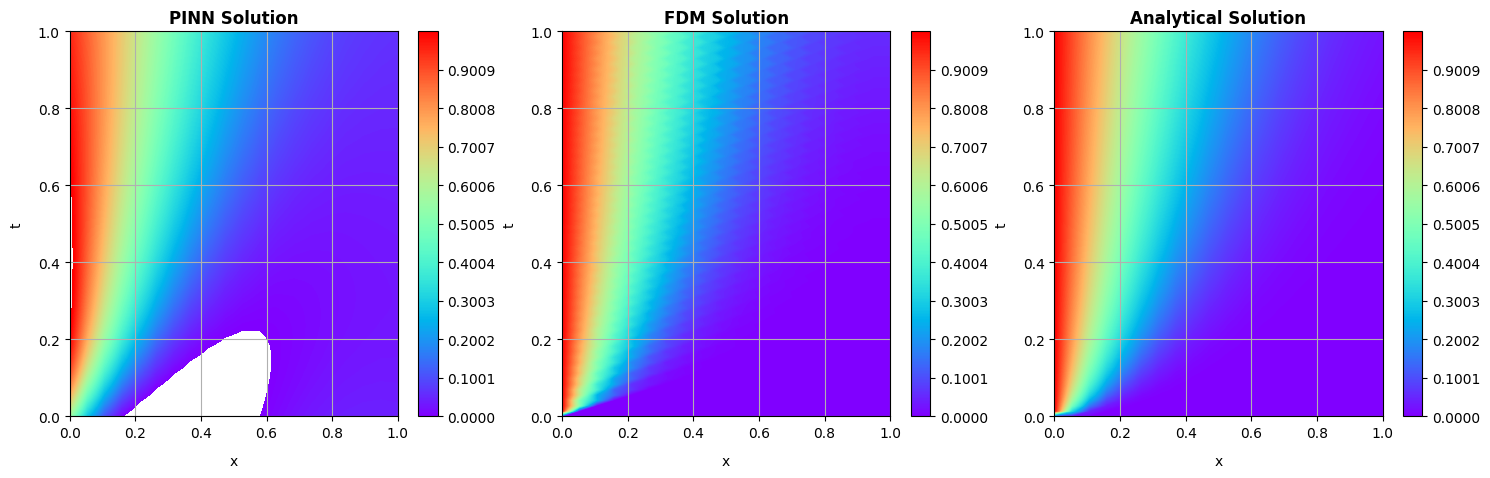

In [9]:
def central_difference(n, i, delta_x, delta_t, c):
    return c[n][i] + delta_t * (D * (c[n][i+1] - 2*c[n][i] + c[n][i-1])/(delta_x)**2)


points_in_x = 20
x = np.linspace(0, 1, points_in_x)
delta_x = x[1] - x[0]
delta_t = 0.5 * delta_x**2 / D
points_in_t = int(1.0/delta_t)
t = np.linspace(0, 1, points_in_t)
delta_t = t[1] - t[0]
c = np.zeros((len(t), len(x)))
c[0, :] = 0

for n in range(0, len(t)-1):
    c[n+1, 0] = c0
    for i in range(1, len(x)-1):
        c[n+1][i] = central_difference(n, i, delta_x, delta_t, c)
    c[n+1, -1] = c[n+1, -2]

def eval_model(m):
    mlp.eval()
    with torch.no_grad():
        p = mlp(torch.tensor(m).float().to(device)).cpu().numpy()
    return p

def analytical_solution(x, t, D, c0):
    if t == 0:
        return np.zeros_like(x)
    return c0 * (1 - sp.erf(x / np.sqrt(4 * D * t)))

X, T = np.meshgrid(x, t)
full_mesh = np.hstack([X.reshape(-1,1), T.reshape(-1,1)])
pinn_pred = eval_model(full_mesh).reshape(X.shape)

analytical_pred = np.array([[analytical_solution(xi, ti, D, c0) for xi in x] for ti in t])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

titles = ['PINN Solution', 'FDM Solution', 'Analytical Solution']
data = [pinn_pred, c, analytical_pred]

for ax, d, title in zip(axes, data, titles):
    img = ax.contourf(x, t, d, levels=np.linspace(0, c0, 1000), cmap='rainbow')
    fig.colorbar(img, ax=ax)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('x', labelpad=10)
    ax.set_ylabel('t', labelpad=10)
    ax.grid()

plt.savefig('1DSoluteDiffusion_Comparison.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()


# Evaluation/Basic Plots


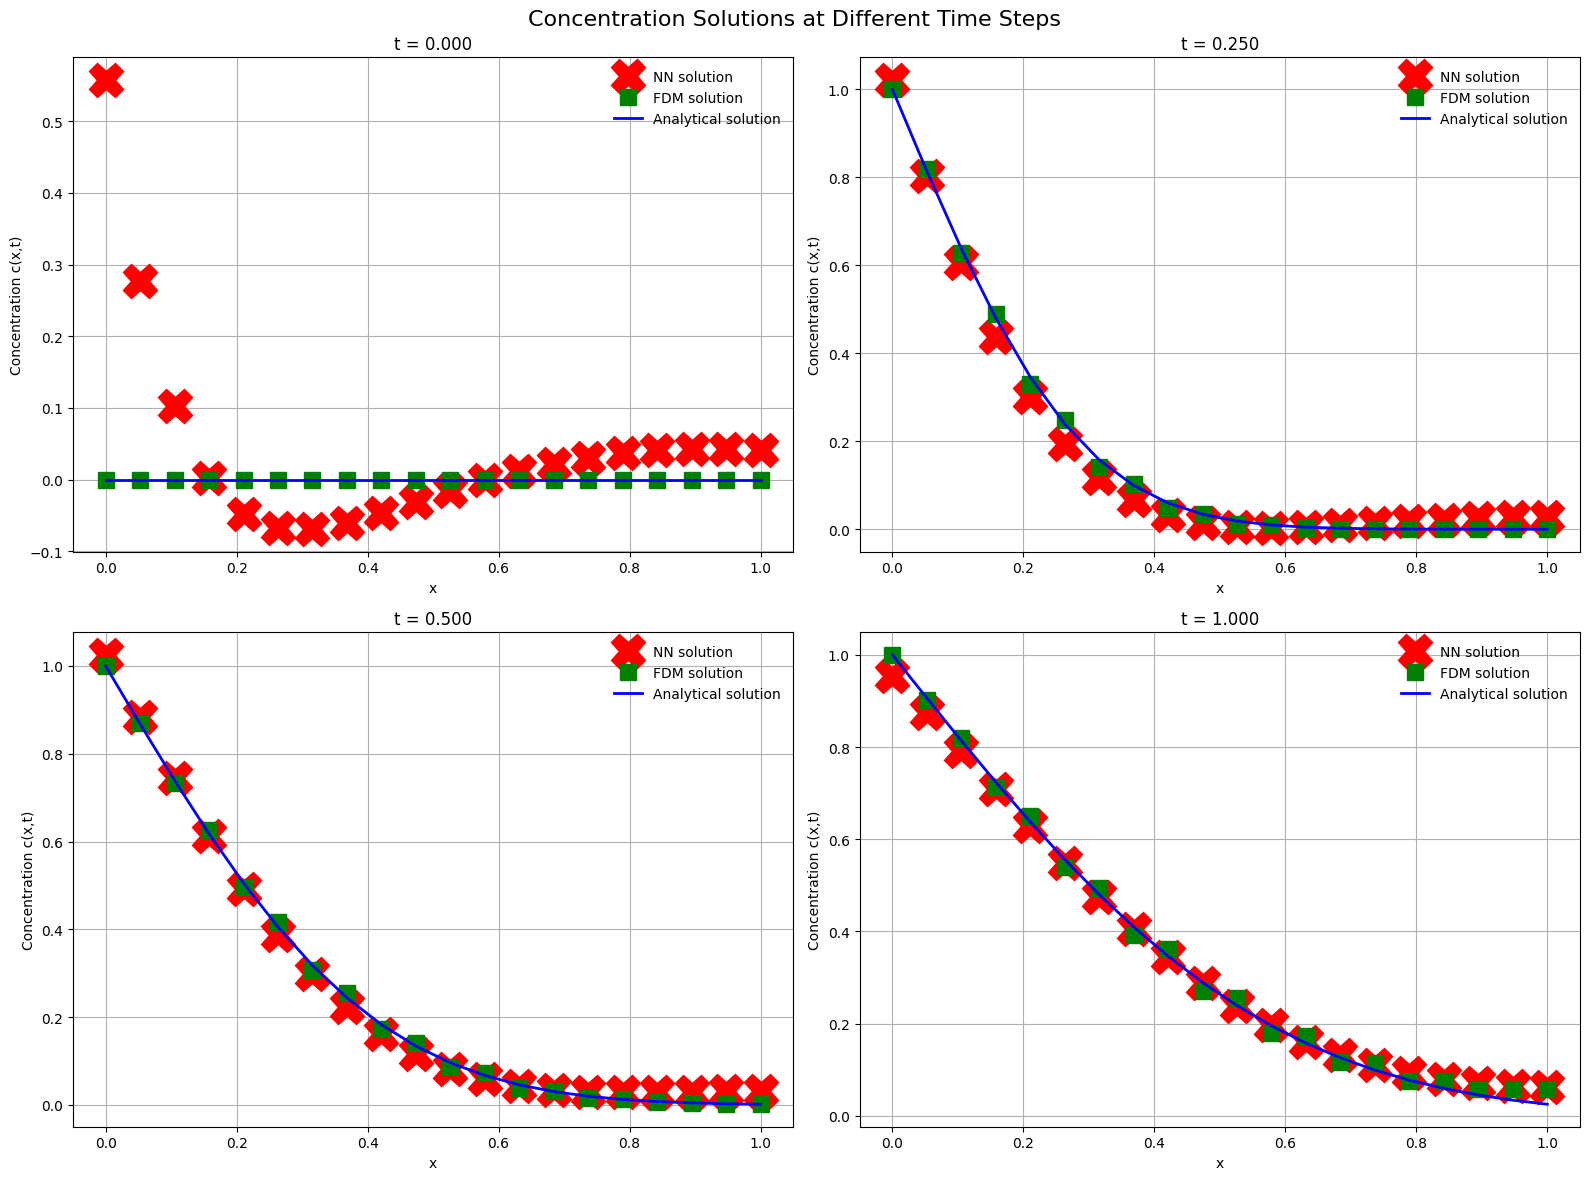

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def build_mesh(N, t_val):
    x_vals = np.linspace(0, 1, N)
    _t = np.array([t_val])
    m = np.meshgrid(x_vals, _t)
    m = np.stack(m, -1).reshape(-1, 2)
    return x_vals, t_val, m

x1, t1, m1 = build_mesh(20, 0)
x2, t2, m2 = build_mesh(20, 0.25)
x3, t3, m3 = build_mesh(20, 0.5)
x5, t5, m5 = build_mesh(20, 1)

p1 = eval_model(m1)
p2 = eval_model(m2)
p3 = eval_model(m3)
p5 = eval_model(m5)

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Concentration Solutions at Different Time Steps', fontsize=16)

time_steps = [0, 0.25, 0.5, 1]
meshes = [m1, m2, m3, m5]
p_solutions = [p1, p2, p3, p5]
x_values = [x1, x2, x3, x5]

for i, (t_val, m, p, x) in enumerate(zip(time_steps, meshes, p_solutions, x_values)):
    row = i // 2
    col = i % 2

    c_fdm = c[int(t_val*len(t)), :] if t_val < 1 else c[-1, :]
    c_analytical = analytical_solution(x, t_val, D, c0)

    axs[row, col].plot(x, p, ms=25, marker='X', color='r', linestyle='None', label="NN solution")
    axs[row, col].plot(x, c_fdm, ms=12, marker='s', color='g', linestyle='None', label="FDM solution")
    axs[row, col].plot(x, c_analytical, 'b-', linewidth=2, label="Analytical solution")

    axs[row, col].set_title(f't = {t_val:.3f}')
    axs[row, col].set_xlabel('x')
    axs[row, col].set_ylabel('Concentration c(x,t)')
    axs[row, col].grid(True)
    axs[row, col].legend(loc='best', frameon=False)

plt.tight_layout()
plt.show()


#More plots

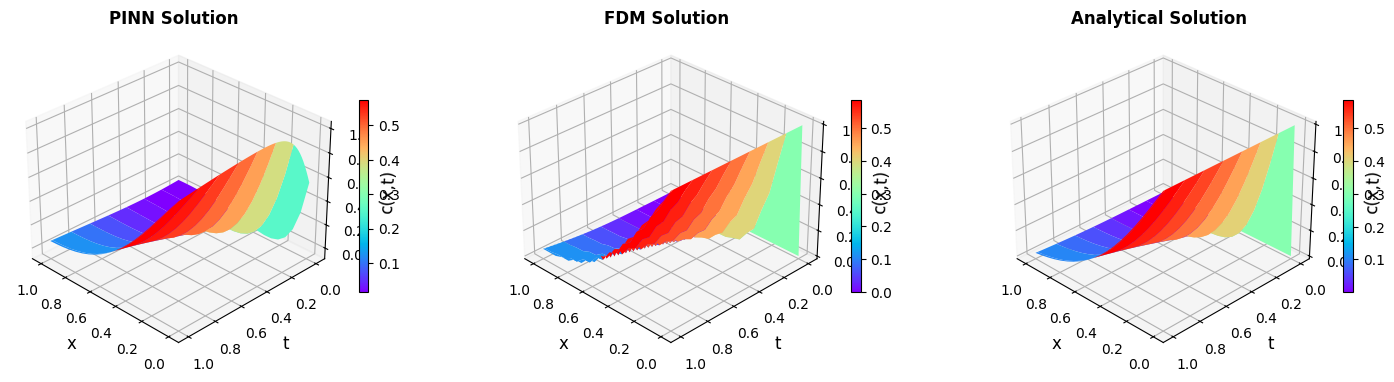

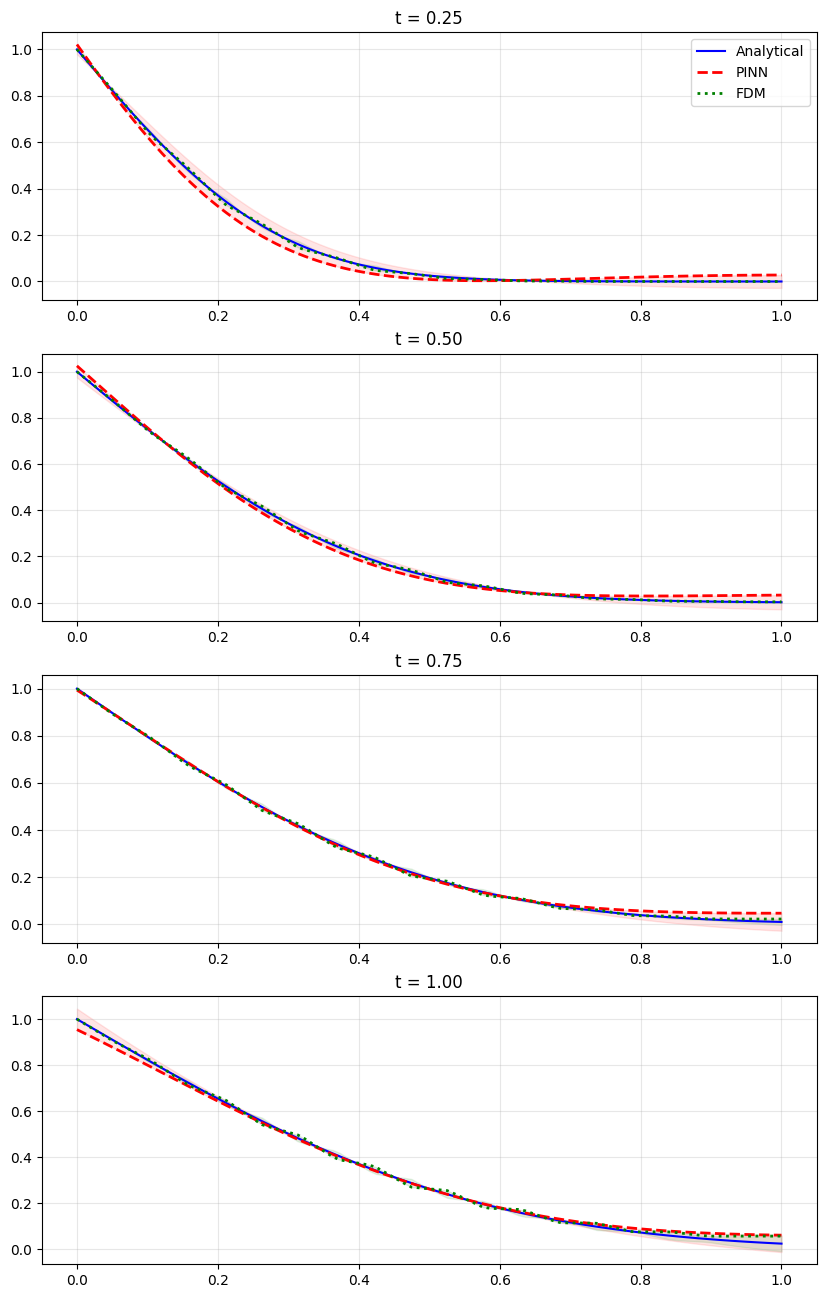

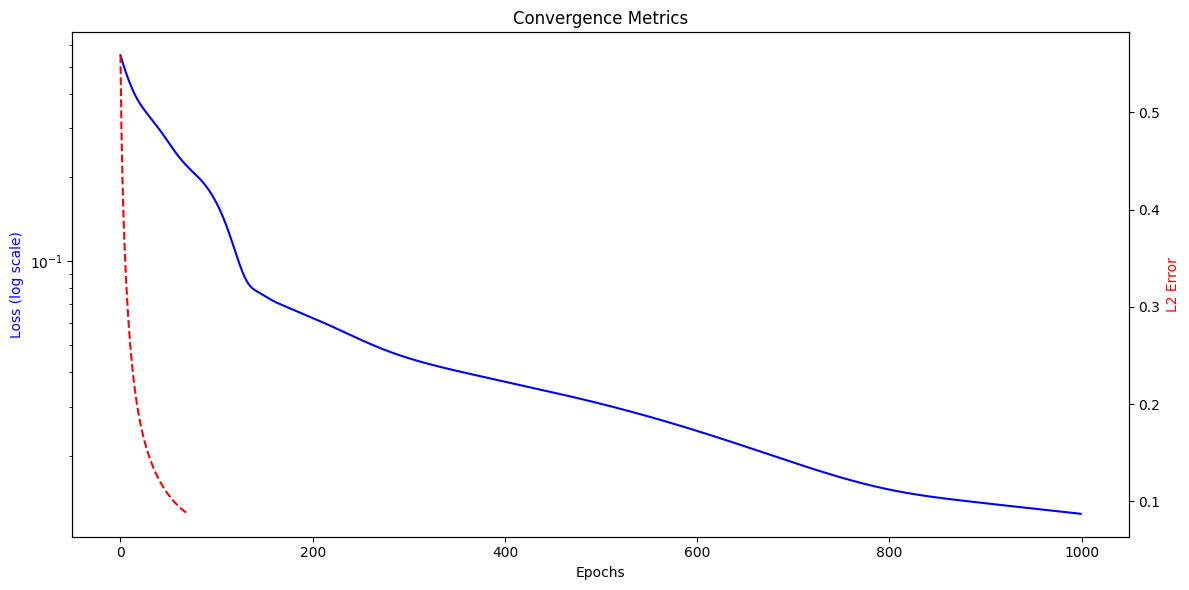

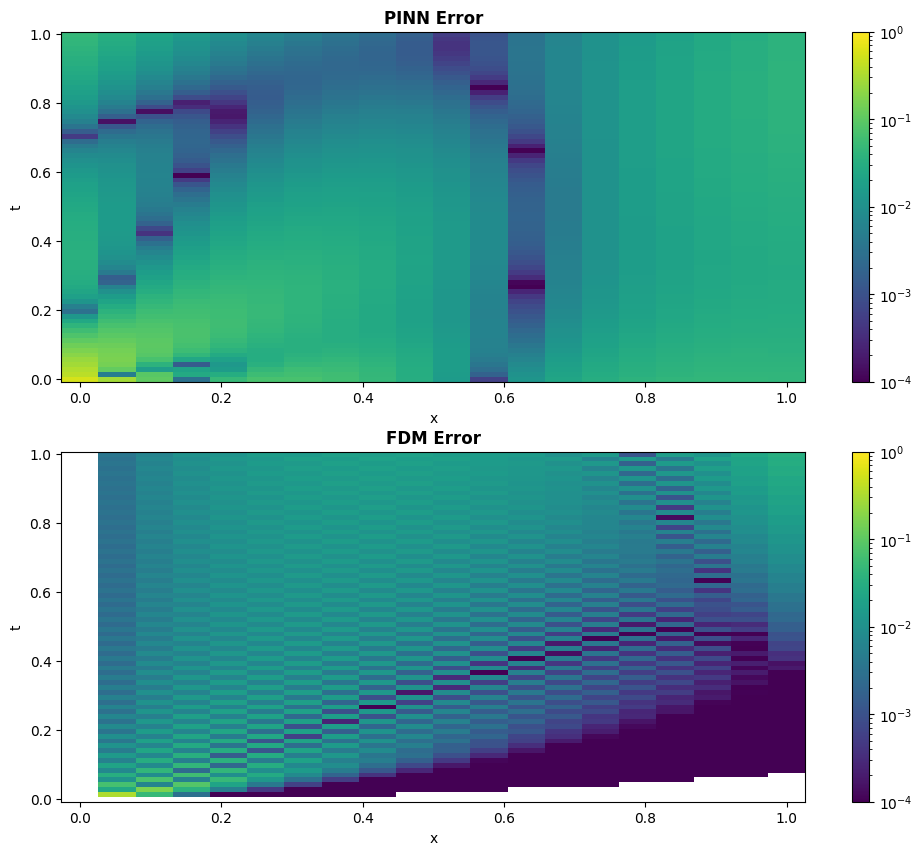

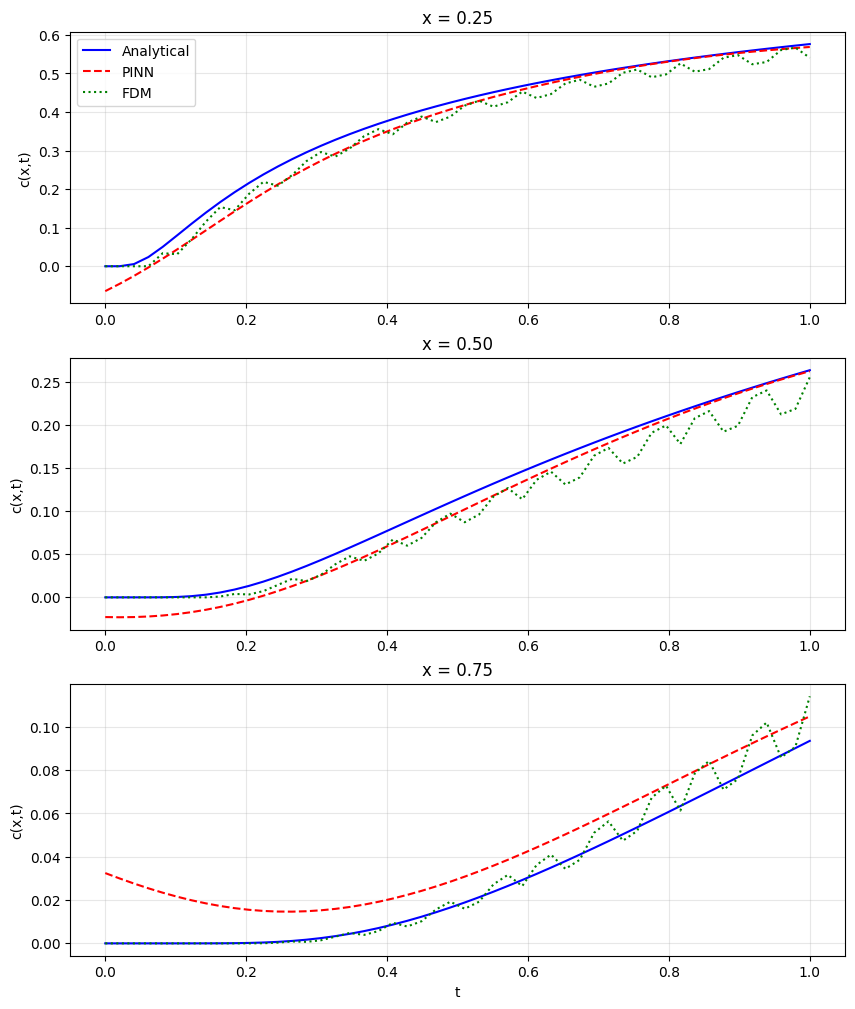

In [12]:
def plot_3d_surfaces():
    X, T = np.meshgrid(x, t)
    full_mesh = np.hstack([X.reshape(-1,1), T.reshape(-1,1)])
    pinn_pred = eval_model(full_mesh).reshape(X.shape)
    fig = plt.figure(figsize=(18,5))
    titles = ['PINN Solution', 'FDM Solution', 'Analytical Solution']
    data = [pinn_pred, c, np.array([[analytical_solution(xi, ti, D, c0) for xi in x] for ti in t])]
    for i in range(3):
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        surf = ax.plot_surface(X, T, data[i], cmap='rainbow', rstride=10, cstride=10)
        ax.view_init(30, 135)
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('t', fontsize=12)
        ax.set_zlabel('c(x,t)', fontsize=12)
        ax.set_title(titles[i], fontweight='bold')
        fig.colorbar(surf, ax=ax, shrink=0.5)
    plt.savefig('3D_Surface_Comparison.png', dpi=300, bbox_inches='tight')

def plot_error_snapshots():
    times = [0.25, 0.5, 0.75, 1.0]
    fig, axs = plt.subplots(4, 1, figsize=(10, 16))
    x_fdm = np.linspace(0, 1, 20)
    for idx, t_val in enumerate(times):
        x_vals, _, mesh = build_mesh(100, t_val)
        pinn = eval_model(mesh).squeeze()
        fdm_idx = int(np.round(t_val * (len(t)-1)))
        fdm_native = c[fdm_idx, :]
        fdm = np.interp(x_vals, x_fdm, fdm_native).squeeze()
        analytic = analytical_solution(x_vals, t_val, D, c0).squeeze()
        axs[idx].plot(x_vals, analytic, 'b-', label='Analytical')
        axs[idx].plot(x_vals, pinn, 'r--', linewidth=2, label='PINN')
        axs[idx].plot(x_vals, fdm, 'g:', linewidth=2, label='FDM')
        pinn_err = np.abs(pinn - analytic)
        fdm_err = np.abs(fdm - analytic)
        axs[idx].fill_between(x_vals, analytic - pinn_err, analytic + pinn_err, color='r', alpha=0.1)
        axs[idx].fill_between(x_vals, analytic - fdm_err, analytic + fdm_err, color='g', alpha=0.1)
        axs[idx].set_title(f't = {t_val:.2f}', fontsize=12)
        axs[idx].grid(True, alpha=0.3)
        if idx == 0:
            axs[idx].legend(loc='upper right')
    plt.savefig('Multi_Time_Error_Snapshots.png', dpi=300, bbox_inches='tight')

def plot_convergence_metrics():
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.semilogy(A_hist[:,0], A_hist[:,1], 'b-', label='Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss (log scale)', color='b')
    X, T = np.meshgrid(x, t)
    full_mesh = np.hstack([X.reshape(-1,1), T.reshape(-1,1)])
    pinn_full = eval_model(full_mesh).reshape(X.shape)
    analytic_full = np.array([[analytical_solution(xi, max(ti,1e-6), D, c0) for xi in x] for ti in t])
    eps = 1e-12
    l2_errors = [np.linalg.norm(pinn_full[:i] - analytic_full[:i]) / (np.linalg.norm(analytic_full[:i]) + eps) for i in range(1, len(t))]
    ax2 = ax1.twinx()
    ax2.plot(l2_errors, 'r--', label='Relative L2 Error')
    ax2.set_ylabel('L2 Error', color='r')
    plt.title('Convergence Metrics')
    fig.tight_layout()
    plt.savefig('Convergence_Dashboard.png', dpi=300, bbox_inches='tight')

def plot_error_heatmaps():
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    X, T = np.meshgrid(x, t)
    pinn_full = eval_model(np.hstack([X.reshape(-1,1), T.reshape(-1,1)])).reshape(X.shape)
    analytic_full = np.array([[analytical_solution(xi, ti, D, c0) for xi in x] for ti in t])
    pinn_err = np.abs(pinn_full - analytic_full)
    fdm_err = np.abs(c - analytic_full)
    for ax, data, title in zip([ax1, ax2], [pinn_err, fdm_err], ['PINN Error', 'FDM Error']):
        im = ax.pcolormesh(X, T, data, norm=mpl.colors.LogNorm(vmin=1e-4, vmax=1), cmap='viridis')
        fig.colorbar(im, ax=ax)
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel('x')
        ax.set_ylabel('t')
    plt.savefig('Error_Heatmaps.png', dpi=300, bbox_inches='tight')

def plot_temporal_evolution():
    x_points = [0.25, 0.5, 0.75]
    fig, axs = plt.subplots(len(x_points), 1, figsize=(10, 12))
    x_fdm = np.linspace(0, 1, 20)
    for idx, x_val in enumerate(x_points):
        t_vals = np.linspace(0, 1, 50)
        pinn_t = []
        analytic_t = []
        fdm_t = []
        for ti in t_vals:
            safe_t = max(ti, 1e-6) if ti == 0 else ti
            _, _, mesh = build_mesh(1, ti)
            mesh[:,0] = x_val
            pinn_t.append(eval_model(mesh)[0])
            analytic_t.append(analytical_solution(x_val, safe_t, D, c0))
            fdm_idx_t = int(np.round(ti * (len(t)-1)))
            fdm_idx_x = np.argmin(np.abs(x_fdm - x_val))
            fdm_t.append(c[fdm_idx_t, fdm_idx_x])
        axs[idx].plot(t_vals, analytic_t, 'b-', label='Analytical')
        axs[idx].plot(t_vals, pinn_t, 'r--', label='PINN')
        axs[idx].plot(t_vals, fdm_t, 'g:', label='FDM')
        axs[idx].set_title(f'x = {x_val:.2f}', fontsize=12)
        axs[idx].grid(True, alpha=0.3)
        axs[idx].set_ylabel('c(x,t)')
        if idx == 0:
            axs[idx].legend()
    axs[-1].set_xlabel('t')
    plt.savefig('Temporal_Evolution.png', dpi=300, bbox_inches='tight')

plot_3d_surfaces()
plot_error_snapshots()
plot_convergence_metrics()
plot_error_heatmaps()
plot_temporal_evolution()
